In [1]:
import sys
from typing import List, Tuple, Set
import heapq
from multiprocessing import Pool, Manager, cpu_count
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../..')
from utils import set_seed, plot_gantt

# Set random seed for reproducibility
set_seed(42)

In [2]:
# Load the scheduling data
schedules_df = pd.read_csv('../../data/schedules.csv')
processing_times = schedules_df['processing_time'].values
release_dates = schedules_df['release_date'].values
n_jobs = len(schedules_df)
print(f"Loaded {n_jobs} jobs")
schedules_df.head()

Loaded 100 jobs


,processing_time,release_date
0,62,0
1,47,1
2,66,2
3,88,4
4,44,18


In [ ]:
class ParallelBranchAndBound:
    """
    A class to solve the single-machine scheduling problem with release dates using parallel Branch and Bound.
    
    Attributes:
        p (np.ndarray): Processing times for each job.
        r (np.ndarray): Release dates for each job.
        n (int): Number of jobs.
        best_makespan (float): The best makespan found so far.
        best_sequence (List[int] or None): The sequence of jobs that achieves the best makespan.
        nodes_explored (int): Number of nodes explored in the search tree.
    """
    
    def __init__(self, processing_times: np.ndarray, release_dates: np.ndarray):
        """
        Initializes the ParallelBranchAndBound instance.
        
        Args:
            processing_times (np.ndarray): Array of processing times for each job.
            release_dates (np.ndarray): Array of release dates for each job.
        """
        self.p = processing_times
        self.r = release_dates
        self.n = len(processing_times)
        self.best_makespan = float('inf')
        self.best_sequence = None
        self.nodes_explored = 0

    def lower_bound(self, current_time: float, remaining: Set[int]) -> float:
        """
        Computes a lower bound for the remaining jobs.
        
        Args:
            current_time (float): The current time in the schedule.
            remaining (Set[int]): Set of remaining job indices.
        
        Returns:
            float: The lower bound on the makespan.
        """
        if not remaining:
            return current_time
        sum_processing = sum(self.p[job] for job in remaining)
        max_lower_bound = current_time + sum_processing
        for job in remaining:
            start_time = max(self.r[job], current_time)
            completion_time = start_time + self.p[job]
            lower_bound_value = completion_time + sum_processing - self.p[job]
            if lower_bound_value > max_lower_bound:
                max_lower_bound = lower_bound_value
        return max_lower_bound

    def branch_and_bound_sequential(self, initial_job: int = None, shared_best=None) -> Tuple[List[int], float, int]:
        """
        Performs the branch and bound search starting from an initial job.
        
        Args:
            initial_job (int, optional): The first job to schedule. If None, starts from empty schedule.
            shared_best (dict, optional): Shared dictionary for parallel processes to track best solution.
        
        Returns:
            Tuple[List[int], float, int]: The best sequence, makespan, and number of nodes explored.
        """
        priority_queue = []
        nodes_explored = 0
        
        if initial_job is not None:
            remaining_jobs = set(range(self.n)) - {initial_job}
            start_time = max(self.r[initial_job], 0)
            current_time = start_time + self.p[initial_job]
            sequence = [initial_job]
            lower_bound_value = self.lower_bound(current_time, remaining_jobs)
            heapq.heappush(priority_queue, (lower_bound_value, current_time, tuple(sequence), frozenset(remaining_jobs)))
            best_makespan = float('inf')
        else:
            remaining_jobs = set(range(self.n))
            heapq.heappush(priority_queue, (0, 0, (), frozenset(remaining_jobs)))
            best_makespan = float('inf')
        
        best_sequence = None
        
        while priority_queue:
            lower_bound_value, current_time, sequence, remaining_jobs = heapq.heappop(priority_queue)
            nodes_explored += 1
            
            current_best = shared_best['value'] if shared_best else best_makespan
            if lower_bound_value >= current_best:
                continue
            
            if not remaining_jobs:
                if current_time < current_best:
                    best_makespan = current_time
                    best_sequence = list(sequence)
                    if shared_best:
                        if current_time < shared_best['value']:
                            shared_best['value'] = current_time
                            shared_best['sequence'] = best_sequence
                continue
            
            for job in remaining_jobs:
                new_remaining = remaining_jobs - {job}
                start_time = max(self.r[job], current_time)
                new_time = start_time + self.p[job]
                new_sequence = sequence + (job,)
                new_lower_bound = self.lower_bound(new_time, new_remaining)
                
                current_best = shared_best['value'] if shared_best else best_makespan
                if new_lower_bound < current_best:
                    heapq.heappush(priority_queue, (new_lower_bound, new_time, new_sequence, frozenset(new_remaining)))
        
        return best_sequence, best_makespan, nodes_explored

def worker_func(initial_job: int, p: np.ndarray, r: np.ndarray, n: int, shared_dict) -> Tuple[List[int], float, int]:
    """
    Worker function for parallel processing.
    
    Args:
        initial_job (int): The job to start the schedule with.
        p (np.ndarray): Processing times array.
        r (np.ndarray): Release dates array.
        n (int): Number of jobs.
        shared_dict (dict): Shared dictionary for tracking best solution across workers.
    
    Returns:
        Tuple[List[int], float, int]: Best sequence, makespan, and nodes explored by this worker.
    """
    solver = ParallelBranchAndBound(p, r)
    sequence, makespan, nodes = solver.branch_and_bound_sequential(initial_job, shared_dict)
    return sequence, makespan, nodes

def solve_parallel(processing_times: np.ndarray, release_dates: np.ndarray, n_workers: int = None) -> Tuple[List[int], float, int]:
    """
    Solves the scheduling problem using parallel branch and bound.
    
    Args:
        processing_times (np.ndarray): Array of processing times for each job.
        release_dates (np.ndarray): Array of release dates for each job.
        n_workers (int, optional): Number of parallel workers. Defaults to CPU count.
    
    Returns:
        Tuple[List[int], float, int]: The best sequence, makespan, and total nodes explored.
    """
    if n_workers is None:
        n_workers = cpu_count()
    
    n = len(processing_times)
    
    with Manager() as manager:
        shared_dict = manager.dict()
        shared_dict['value'] = float('inf')
        shared_dict['sequence'] = None
        
        worker_partial = partial(worker_func, p=processing_times, r=release_dates, n=n, shared_dict=shared_dict)
        
        with Pool(n_workers) as pool:
            results = pool.map(worker_partial, range(n))
        
        best_makespan = float('inf')
        best_sequence = None
        total_nodes = 0
        
        for sequence, makespan, nodes in results:
            total_nodes += nodes
            if sequence and makespan < best_makespan:
                best_makespan = makespan
                best_sequence = sequence
        
        if shared_dict['sequence'] and shared_dict['value'] < best_makespan:
            best_makespan = shared_dict['value']
            best_sequence = shared_dict['sequence']
        
        return best_sequence, best_makespan, total_nodes

best_seq, best_mk, nodes = solve_parallel(processing_times, release_dates)
print("Best sequence:", best_seq)
print("Makespan:", best_mk)
print("Nodes explored:", nodes)

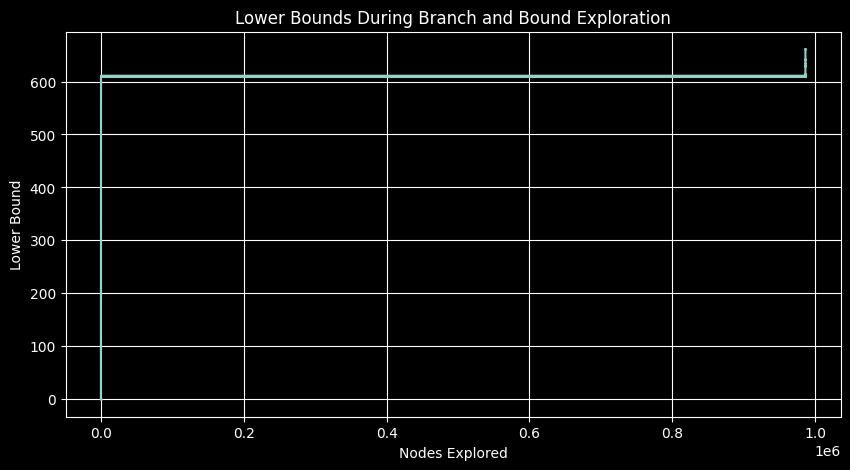

In [ ]:
# Visualize the bounds during exploration
plt.figure(figsize=(10, 5))
plt.plot(bb.bounds, marker='o', markersize=1)
plt.title('Lower Bounds During Branch and Bound Exploration')
plt.xlabel('Nodes Explored')
plt.ylabel('Lower Bound')
plt.grid(True)
plt.show()

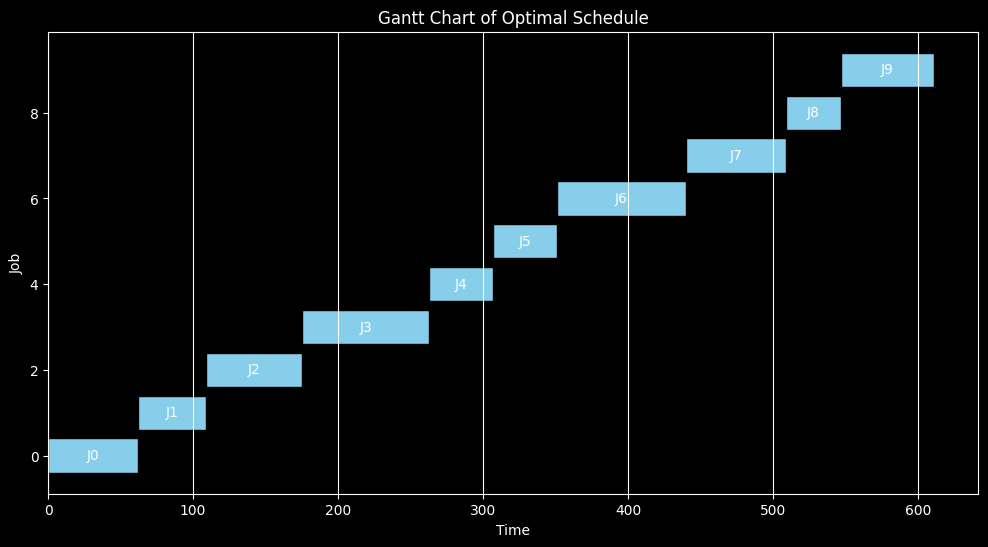

In [ ]:
# Visualize the best schedule as a Gantt chart
plot_gantt(best_seq, processing_times, release_dates)